<a href="https://colab.research.google.com/github/carloscesar182/ai_advanced_course/blob/main/Notebooks/FinalProject/ProjetoFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto Final do Curso de IA
Treinar um modelo buscando a melhor performance possível
---
## Bibliotecas

In [1]:
# instalar o AutoML 2.0 para que ele me sugira os melhores modelos para essa base
!pip install -q h2o

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.9/265.9 MB 5.6 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import h2o
import xgboost as xgb
from xgboost import XGBClassifier
from h2o.automl import H2OAutoML
from h2o.frame import H2OFrame
from h2o.estimators import H2ORandomForestEstimator
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from yellowbrick.classifier import ConfusionMatrix

## Importação dos arquivos para o modelo

### Base de treino

In [6]:
# importar a base de treino
train = pd.read_csv('train.csv')

# olhar a estrutura da tabela
train.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,188767,HS-grad,9,Never-married,Craft-repair,Own-child,White,Male,0,0,40,United-States,<=50K
1,64,Private,286732,HS-grad,9,Widowed,Sales,Not-in-family,White,Female,0,0,17,United-States,<=50K
2,29,Private,253801,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,Ecuador,<=50K
3,28,Private,334032,Assoc-voc,11,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,50,United-States,<=50K
4,22,Private,173004,HS-grad,9,Never-married,Machine-op-inspct,Other-relative,Black,Male,0,0,1,United-States,<=50K


In [7]:
# verificar se tem dados nulos em alguma coluna
train.isnull().sum()

,0
age,0
workclass,0
fnlwgt,0
education,0
educational-num,0
marital-status,0
occupation,0
relationship,0
race,0
gender,0


In [8]:
# verificar dados faltantes. Percebi que existem algumas linhas com '?'
train.select_dtypes(include=['object']).apply(lambda x: x.str.contains(r'\?', na=False).sum())

,0
workclass,1969
education,0
marital-status,0
occupation,1977
relationship,0
race,0
gender,0
native-country,585
income,0


In [9]:
# substituir o '?' por 'Not-informed' com hífen pra manter o padrão das outras colunas
train.replace('?', 'Not-informed', inplace=True)

# verificar se funcionou
train.select_dtypes(include=['object']).apply(lambda x: x.str.contains(r'\?', na=False).sum())

,0
workclass,0
education,0
marital-status,0
occupation,0
relationship,0
race,0
gender,0
native-country,0
income,0


### Base de Validação

In [10]:
validation = pd.read_csv('validation.csv') # importa o modelo
validation.head() # valida a estrutura

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,22,Private,174043,HS-grad,9,Never-married,Craft-repair,Not-in-family,White,Male,0,0,50,United-States,<=50K
1,50,State-gov,159219,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,Canada,>50K
2,18,?,192399,Some-college,10,Never-married,?,Own-child,White,Male,0,0,60,United-States,<=50K
3,33,Federal-gov,193246,Bachelors,13,Married-civ-spouse,Adm-clerical,Husband,White,Male,0,0,42,United-States,>50K
4,23,Private,61777,Bachelors,13,Married-civ-spouse,Sales,Husband,White,Male,2580,0,40,United-States,<=50K


In [11]:
# verificar se tem dados nulos em alguma coluna
validation.isnull().sum()

,0
age,0
workclass,0
fnlwgt,0
education,0
educational-num,0
marital-status,0
occupation,0
relationship,0
race,0
gender,0


In [12]:
# verificar dados faltantes
validation.select_dtypes(include=['object']).apply(lambda x: x.str.contains(r'\?', na=False).sum())

,0
workclass,404
education,0
marital-status,0
occupation,405
relationship,0
race,0
gender,0
native-country,138
income,0


In [13]:
# substituir o '?' por 'Not-informed'
validation.replace('?', 'Not-informed', inplace=True)

# verificar se funcionou
validation.select_dtypes(include=['object']).apply(lambda x: x.str.contains(r'\?', na=False).sum())

,0
workclass,0
education,0
marital-status,0
occupation,0
relationship,0
race,0
gender,0
native-country,0
income,0


## Definição das variáveis

In [16]:
# definição das variáveis
# sem usar o .values no final, deixa o padrão de dataframe do pandas e é melhor pra pre processamento
# usando .values no final, deixa como array do numpy e é mais leve e melhor pra treinar o modelo
X = train.drop(train.columns[14], axis=1) # variáveis independentes
y = train.iloc[:, 14] # variável dependente

# variáveis para validação
# passei exatamente da mesma forma para garantir que as duas bases estão iguais
X_val = validation.drop(validation.columns[14], axis=1)
y_val = validation.iloc[:, 14]

In [17]:
# confirmar os tamanhos das bases
print(f"X: {X.shape}")
print(f"y: {y.shape}")
print(f"X_val: {X_val.shape}")
print(f"y_val: {y_val.shape}")

X: (34189, 14)
y: (34189,)
X_val: (7326, 14)
y_val: (7326,)


## Pré processamento

### Outliers

In [18]:
# detectar e listar colunas numéricas
colunas_numericas = X.select_dtypes(include=['int64', 'float64']).columns
print(colunas_numericas)

# iqr colunas numéricas dentro de um laço
resultados_iqr = {} # dicionário pra armazenar os resultados
for coluna in colunas_numericas:
  q1 = X[coluna].quantile(0.25)
  q3 = X[coluna].quantile(0.75)
  iqr = q3 - q1
  limite_inf = q1 - 1.5 * iqr
  limite_sup = q3 + 1.5 * iqr
  mediana = X[coluna].median()
  outliers = X[(X[coluna] < limite_inf) | (X[coluna] > limite_sup)]
  resultados_iqr[coluna] = {
      'q1': q1,
      'q3': q3,
      'iqr': iqr,
      'limite_inf': limite_inf,
      'limite_sup': limite_sup,
      'mediana': mediana,
      'outliers': len(outliers)
    }

print(f"Outliers para Age: {resultados_iqr['age']}")
print(f"Outliers para Fnlwgt: {resultados_iqr['fnlwgt']}")
print(f"Outliers para Education Num: {resultados_iqr['educational-num']}")
print(f"Outliers para Capital Gain: {resultados_iqr['capital-gain']}")
print(f"Outliers para Capital Loss: {resultados_iqr['capital-loss']}")
print(f"Outliers para Hours Per Week: {resultados_iqr['hours-per-week']}")

Index(['age', 'fnlwgt', 'educational-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object')
Outliers para Age: {'q1': np.float64(28.0), 'q3': np.float64(48.0), 'iqr': np.float64(20.0), 'limite_inf': np.float64(-2.0), 'limite_sup': np.float64(78.0), 'mediana': 37.0, 'outliers': 152}
Outliers para Fnlwgt: {'q1': np.float64(117674.0), 'q3': np.float64(237720.0), 'iqr': np.float64(120046.0), 'limite_inf': np.float64(-62395.0), 'limite_sup': np.float64(417789.0), 'mediana': 177937.0, 'outliers': 1019}
Outliers para Education Num: {'q1': np.float64(9.0), 'q3': np.float64(12.0), 'iqr': np.float64(3.0), 'limite_inf': np.float64(4.5), 'limite_sup': np.float64(16.5), 'mediana': 10.0, 'outliers': 1267}
Outliers para Capital Gain: {'q1': np.float64(0.0), 'q3': np.float64(0.0), 'iqr': np.float64(0.0), 'limite_inf': np.float64(0.0), 'limite_sup': np.float64(0.0), 'mediana': 0.0, 'outliers': 2828}
Outliers para Capital Loss: {'q1': np.float64(0.0), 'q3': np.float64(0.0)

**Análise e sugestões por coluna**

**Age:** Limites entre -2 e 78 anos = valores negativos não existem, então só faz sentido considerar outliers acima de 78 anos. Como são poucos casos, provavelmente pessoas muito idosas no dataset, o que pode ser real. Não vou remover ou substituir, pois pode ser informação válida.

**Fnlwgt (final weight):**
Variável que indica o peso da amostra na população e tem uma variação muito grande. Muitos valores grandes podem ser corretos e relevantes. Como o intervalo IQR é amplo e o limite superior é alto, os valores que excedem o limite podem não ser verdadeiros "outliers" para remoção. Vou manter como estão.

**Education Num:** Varia entre 1 e 16 (anos de educação). O limite superior do IQR é 16.5 (sendo o máximo 16?), então valores acima disso são estranhos, mas talvez não existam. Poderia verificar quais valores estão fora desse limite e entender se são erros de entrada mas não vale a pena e não vou mexer.

**Capital Gain e Capital Loss:** A concentração em zero é bem grande, o que parece comum nesse dataset. O IQR = 0 indica que a mediana e limites coincidem com zero, e qualquer valor positivo será considerado outlier segundo a regra padrão de IQR. Vou considerar esses zeros como "normais" e valores positivos como raros. Não vou remover ou substituir, pois o ganho/perda de capital pode ser um forte indicador em renda.

**Hours Per Week:** Tenho 9508 amostras fora do intervalo considerado normal (32.5 a 52.5). Isso inclui quem trabalha poucas horas (ex. 1 hora) e quem trabalha muito (ex. 60+ horas). Considerei possíveis outliers as linhas que tem mais de 80 horas por semana trabalhadas com idade > 60 e income < 50k mas só encontrei 15 casos, o que pode ser normal. Decidi então não alterar nada e seguir com os dados originais.

In [19]:
# filtrar quem trabalha mais de 80h, tem mais de 60 anos e ganha menos de 50k
filtro_outlier = (X['hours-per-week'] > 80) & (X['age'] > 60) & (y == '<=50K')
print(f"Quantidade de outliers: {filtro_outlier.sum()}")

Quantidade de outliers: 15


In [20]:
# detectar e listar colunas numéricas da validação
colunas_numericas = X_val.select_dtypes(include=['int64', 'float64']).columns
print(colunas_numericas)

# iqr colunas numéricas dentro de um laço
resultados_iqr = {} # dicionário pra armazenar os resultados
for coluna in colunas_numericas:
  q1 = X_val[coluna].quantile(0.25)
  q3 = X_val[coluna].quantile(0.75)
  iqr = q3 - q1
  limite_inf = q1 - 1.5 * iqr
  limite_sup = q3 + 1.5 * iqr
  mediana = X_val[coluna].median()
  outliers = X_val[(X[coluna] < limite_inf) | (X[coluna] > limite_sup)]
  resultados_iqr[coluna] = {
      'q1': q1,
      'q3': q3,
      'iqr': iqr,
      'limite_inf': limite_inf,
      'limite_sup': limite_sup,
      'mediana': mediana,
      'outliers': len(outliers)
    }

print(f"Outliers para Age: {resultados_iqr['age']}")
print(f"Outliers para Fnlwgt: {resultados_iqr['fnlwgt']}")
print(f"Outliers para Education Num: {resultados_iqr['educational-num']}")
print(f"Outliers para Capital Gain: {resultados_iqr['capital-gain']}")
print(f"Outliers para Capital Loss: {resultados_iqr['capital-loss']}")
print(f"Outliers para Hours Per Week: {resultados_iqr['hours-per-week']}")

# filtrar quem trabalha mais de 80h, tem mais de 60 anos e ganha menos de 50k
filtro_outlier = (X_val['hours-per-week'] > 80) & (X_val['age'] > 60) & (y_val == '<=50K')
print(f"Quantidade de outliers: {filtro_outlier.sum()}")

Index(['age', 'fnlwgt', 'educational-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object')
Outliers para Age: {'q1': np.float64(28.0), 'q3': np.float64(48.0), 'iqr': np.float64(20.0), 'limite_inf': np.float64(-2.0), 'limite_sup': np.float64(78.0), 'mediana': 37.0, 'outliers': 32}
Outliers para Fnlwgt: {'q1': np.float64(116642.0), 'q3': np.float64(238802.0), 'iqr': np.float64(122160.0), 'limite_inf': np.float64(-66598.0), 'limite_sup': np.float64(422042.0), 'mediana': 179352.0, 'outliers': 186}
Outliers para Education Num: {'q1': np.float64(9.0), 'q3': np.float64(12.0), 'iqr': np.float64(3.0), 'limite_inf': np.float64(4.5), 'limite_sup': np.float64(16.5), 'mediana': 10.0, 'outliers': 279}
Outliers para Capital Gain: {'q1': np.float64(0.0), 'q3': np.float64(0.0), 'iqr': np.float64(0.0), 'limite_inf': np.float64(0.0), 'limite_sup': np.float64(0.0), 'mediana': 0.0, 'outliers': 636}
Outliers para Capital Loss: {'q1': np.float64(0.0), 'q3': np.float64(0.0), 'i

/tmp/ipython-input-2198099957.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  outliers = X_val[(X[coluna] < limite_inf) | (X[coluna] > limite_sup)]
/tmp/ipython-input-2198099957.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  outliers = X_val[(X[coluna] < limite_inf) | (X[coluna] > limite_sup)]
/tmp/ipython-input-2198099957.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  outliers = X_val[(X[coluna] < limite_inf) | (X[coluna] > limite_sup)]
/tmp/ipython-input-2198099957.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  outliers = X_val[(X[coluna] < limite_inf) | (X[coluna] > limite_sup)]
/tmp/ipython-input-2198099957.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  outliers = X_val[(X[coluna] < limite_inf) | (X[coluna] > limite_sup)]
/tmp/ipython-input-2198099957.py:14: UserWarning: Boolean Series key will b

In [21]:
# filtrar quem trabalha mais de 80h, tem mais de 60 anos e ganha menos de 50k do arquivo de validação
filtro_outlier_val = (X_val['hours-per-week'] > 80) & (X_val['age'] > 60) & (y_val == '<=50K')
print(f"Quantidade de outliers: {filtro_outlier_val.sum()}")

Quantidade de outliers: 4


### Categorização
Transformar as colunas categóricas do tipo 'object' em colunas numéricas

In [25]:
# ver as colunas categóticas do tipo object
print("Colunas categóricas (object):")
print("\nBase de Treino 'X'", X.dtypes[X.dtypes == 'object'])
print("\nBase de Validação 'X_val'", X_val.dtypes[X_val.dtypes == 'object'])

Colunas categóricas (object):

Base de Treino 'X' workclass         object
education         object
marital-status    object
occupation        object
relationship      object
race              object
gender            object
native-country    object
dtype: object

Base de Validação 'X_val' workclass         object
education         object
marital-status    object
occupation        object
relationship      object
race              object
gender            object
native-country    object
dtype: object


In [26]:
# transformar variáveis categóricas em numéricas

# criar uma variável X_encoded pra manter X intacto com dados brutos
X_encoded = X.copy()

# na base de treino usa o fit_transform() para que o LabelEncoder aprenda os mapeamentos das categorias e transforme os dados
label_encoders = {} # dicionário para salvar os encoders e reutilizar na validação, o que é necessário para transformar as mesmas categorias corretamente
for coluna in X_encoded.select_dtypes(include=['object']).columns: # laço pra detectar apenas os objetos que são categóricos, que no pandas é o tipo object e transformar só eles
  le = LabelEncoder()
  X_encoded[coluna] = le.fit_transform(X_encoded[coluna]) # aplica o labelencoder da coluna atual, transforma e coloca no mesmo objeto da coluna atual. Isso vai substituindo as colunas pela mesma informação codificada
  label_encoders[coluna] = le # salva o encoder para validação

# verifica os tipos. Espera-se que não tenham mais colunas do tipo 'object'
print(X_encoded.dtypes)

age                int64
workclass          int64
fnlwgt             int64
education          int64
educational-num    int64
marital-status     int64
occupation         int64
relationship       int64
race               int64
gender             int64
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country     int64
dtype: object


In [27]:
# aplicar o transform na base de validação

# criar uma variável X_val_encoded pra manter X_val intacta com dados brutos
X_val_encoded = X_val.copy()

# na base de validação você usa somente transform(), ou seja, reaplica as mesmas transformações aprendidas na base de treino, sem alterar os mapeamentos
for coluna in X_val_encoded.select_dtypes(include=['object']).columns:
  le = label_encoders[coluna]
  X_val_encoded[coluna] = le.transform(X_val_encoded[coluna])

# verifica os tipos. Espera-se que não tenham mais colunas do tipo 'object'
print(X_val_encoded.dtypes)

age                int64
workclass          int64
fnlwgt             int64
education          int64
educational-num    int64
marital-status     int64
occupation         int64
relationship       int64
race               int64
gender             int64
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country     int64
dtype: object


### Dimensionamento (normalização)
Como as colunas tem valores com ordens de grandeza muito diferentes entre si, faz sentido normalizar essas ordens de grandeza para que o modelo desempenhe melhor ao analisar esses dados.

Exemplo: Coluna 'age' com valores de 0 a 100 vs a coluna 'capital-gain' com valores de 0 a 999999 vão ficar com valores do mesmo tamanho, porém codificados para representar o mesmo estado anterior e não perder a informação.

In [31]:
# fazer o dimensionamento para equalizar a escala dos dados
sc = StandardScaler()

X_scaled = sc.fit_transform(X_encoded) # o fit_transform() do StandardScaler sempre retorna um array NumPy, não um DataFrame pandas
X_val_scaled = sc.transform(X_val_encoded) # na base de validação, uso apenas o transform() para não vazar as infos do conjunto de validação pro modelo

# testando se o standardscaler funcionou
# a média deve estar proxima de 0 e o desvio padrão deve estar próximo de 1
print("Média da base de treino: ", X_scaled[:, 3].mean())
print("Desvio Padrão da base de treino: ", X_scaled[:, 3].std())
print("Média da base de validação: ", X_val_scaled[:, 3].mean())
print("Desvio Padrão da base de validação: ", X_val_scaled[:, 3].std())

Média da base de treino:  1.639761965880017e-16
Desvio Padrão da base de treino:  0.9999999999999998
Média da base de validação:  -0.0027527192885328047
Desvio Padrão da base de validação:  1.0008795956792094


In [33]:
# preparando o y, nosso vetor alvo
print(y.value_counts()) # mostra a contagem de cada valor único

# preparando o y_val
print(y_val.value_counts())

income
<=50K    25922
>50K      8267
Name: count, dtype: int64
income
<=50K    5642
>50K     1684
Name: count, dtype: int64


In [34]:
# aplicar o fit_transform() do labelencoder no y para transformar também em números
le_target = LabelEncoder()

# gera o encode numa variável nova pra manter y intacto
y_encoded = le_target.fit_transform(y)

# aplicar o transform() do labelencoder na base de validação
y_val_encoded = le_target.transform(y_val)

In [39]:
# ver os dados de y transformados. Agora não é mais um dataframe do pandas, e sim um array do numpy
print(f"Dados de Treino transformados na variável 'y_encoded': {np.unique(y_encoded)}")

# ver os dados de y_val transformados
print(f"Dados de Validação transformados na variável 'y_val_encoded': {np.unique(y_val_encoded)}")

# legenda
print("\nLegenda:")
print("0 corresponde a: ", le_target.inverse_transform([0]))
print("1 corresponde a: ", le_target.inverse_transform([1]))

Dados de Treino transformados na variável 'y_encoded': [0 1]
Dados de Validação transformados na variável 'y_val_encoded': [0 1]

Legenda:
0 corresponde a:  ['<=50K']
1 corresponde a:  ['>50K']


### Separação da base de treino e teste
Como já tenho as bases de treino, validação e teste separadas, não vou precisar do train_test_split

## Criação dos modelos

### AutoML (ranking automático de modelos)

In [43]:
# inicia o automl
h2o.init()

# importar os arquivos já pré processados
# converter X_scaled (array NumPy) para DataFrame pandas
X_scaled_df = pd.DataFrame(X_scaled, columns=[f'feature_{i}' for i in range(X_scaled.shape[1])])
y_encoded_series = pd.Series(y_encoded, name='income')

X_val_scaled_df = pd.DataFrame(X_val_scaled, columns=[f'feature_{i}' for i in range(X_val_scaled.shape[1])])
y_val_encoded_series = pd.Series(y_val_encoded, name='income')

# concatena features e target para treino e validação
automl_train_df = pd.concat([X_scaled_df, y_encoded_series], axis=1)
automl_valid_df = pd.concat([X_val_scaled_df, y_val_encoded_series], axis=1)

# converte para H2OFrame
automl_train = H2OFrame(automl_train_df)
automl_valid = H2OFrame(automl_valid_df)

# visualizar os arquivos
automl_train.head()

Checking whether there is an H2O instance running at http://localhost:54321. connected.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,3 mins 30 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.7
H2O_cluster_version_age:,4 months and 25 days
H2O_cluster_name:,H2O_from_python_unknownUser_bjy5o4
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.170 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,income
-0.996239,0.03887,-0.00752487,0.180902,-0.420199,0.921385,-1.03451,0.977602,0.389616,0.704533,-0.14428,-0.220066,-0.0350587,0.287533,0
1.84184,0.03887,0.920502,0.180902,-0.420199,2.25007,1.27365,-0.271118,0.389616,-1.41938,-0.14428,-0.220066,-1.88317,0.287533,0
-0.705153,0.03887,0.608545,0.180902,-0.420199,-0.407304,-1.03451,-0.895478,0.389616,0.704533,-0.14428,-0.220066,-0.0350587,-4.87364,0
-0.777925,0.03887,1.36858,-0.593238,0.357297,-0.407304,-1.03451,-0.895478,0.389616,0.704533,-0.14428,-0.220066,0.768469,0.287533,0
-1.21455,0.03887,-0.156849,0.180902,-0.420199,0.921385,-0.111246,0.353242,-1.97618,0.704533,-0.14428,-0.220066,-3.16882,0.287533,0
-0.195754,0.03887,0.401531,0.180902,-0.420199,-0.407304,-1.03451,-0.895478,0.389616,0.704533,-0.14428,-0.220066,1.89341,0.287533,1
1.76907,0.778395,-0.0815283,-1.62543,-2.75269,-0.407304,1.27365,-0.895478,0.389616,0.704533,-0.14428,-0.220066,-1.24035,0.287533,0
0.968587,0.03887,4.05985,0.180902,-0.420199,-1.73599,0.350386,0.977602,-1.97618,-1.41938,-0.14428,-0.220066,-0.0350587,0.287533,0
-0.195754,0.03887,-0.743003,1.21309,-0.0314509,-0.407304,-1.03451,-0.895478,0.389616,0.704533,-0.14428,-0.220066,0.366705,0.287533,0
-1.3601,0.03887,0.0298368,1.21309,-0.0314509,0.921385,-0.342062,0.977602,0.389616,-1.41938,-0.14428,-0.220066,-0.0350587,0.287533,0


In [44]:
# definir o nome da coluna feature e target
feature_cols = automl_train.columns[:-1]
target_col_name = automl_train.columns[-1]

# converte a coluna target para categórica para classificação binária
automl_train[target_col_name] = automl_train[target_col_name].asfactor()
automl_valid[target_col_name] = automl_valid[target_col_name].asfactor()

# parametros do automl
aml = H2OAutoML(
    max_runtime_secs=300,
    sort_metric='f1',
    seed=42,
    nfolds=0  # desativa cross-validation e usa validação externa
)

# treinamento do automl
aml.train(
    x=feature_cols,
    y=target_col_name,
    training_frame=automl_train,
    validation_frame=automl_valid
)

# ranking dos melhores modelos
lb = aml.leaderboard
print(lb.head())

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
model_id                                                                f1       auc    logloss     aucpr    mean_per_class_error      rmse        mse
GLM_1_AutoML_1_20250822_125504                                    0.612385  0.848873   0.377836  0.67776                 0.248123  0.345402  0.119303
DeepLearning_grid_1_AutoML_1_20250822_125504_model_2              0.649974  0.8803     0.354637  0.722607                0.210161  0.332801  0.110756
DeepLearning_grid_3_AutoML_1_20250822_125504_model_1              0.670439  0.899638   0.32214   0.754882                0.200032  0.318807  0.101638
DeepLearning_1_AutoML_1_20250822_125504                           0.674613  0.901042   0.320158  0.753445                0.187436  0.319158  0.101862
XGBoost_grid_1_AutoML_1_20250822_125504_model_23                  0.682013  0.896417   0.536529  0.760325                0.190681  0.416529  0.173496
Deep

### Criação do top 3 modelos sugeridos pelo AutoML

Peguei o top 3 modelos do ranking que o AutoML gerou por F1 Score e vou usar o treinamento que o AutoML já fez pra gerar as métricas de cada modelo para fins de relatórios.

Eu poderia não vou investir tempo em fine tuning pra cada modelo, dado que o AutoML já faz isso de forma muito boa com busca aleatória e grid search em hiperparâmetros importantes de cada modelo, combina múltiplos modelos e faz empilhamento pra melhorar a performance e também calibra a intensidade do tuning com base no tempo definido pra ele executar os testes. No entanto, vou fazer manualmente o top 3 para fins de aprendizado

### I -> XGBoost

- F1-Score do XGB: 0.7042
- Acurácia do XGB: 0.8729
- Recall do XGB: 0.6580
- Precisão do XGB: 0.7573
- Relatório de Classificação do XGB:
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      5642
           1       0.76      0.66      0.70      1684
      accuracy                         0.87      7326
      macro avg    0.83      0.80      0.81      7326
      weighted avg 0.87      0.87      0.87      7326

F1-Score do XGB: 0.6826
Acurácia do XGB: 0.8621
Recall do XGB: 0.6449
Precisão do XGB: 0.7250
Relatório de Classificação do XGB:
              precision    recall  f1-score   support

           0       0.90      0.93      0.91      5642
           1       0.72      0.64      0.68      1684

    accuracy                           0.86      7326
   macro avg       0.81      0.79      0.80      7326
weighted avg       0.86      0.86      0.86      7326



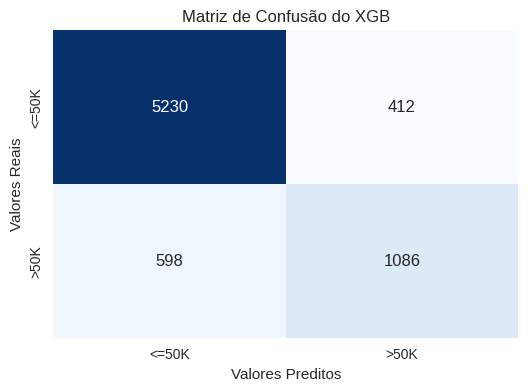

In [45]:
# recuperar o modelo XGBoost do AutoML pelo model_id
model_id = "XGBoost_1_AutoML_1_20250822_125504"
automl_xgb = h2o.get_model(model_id)

# extrair os hiperparâmetros para referência
# print(automl_xgb.params)

# definir o modelo base XGBClassifier com hiperparâmetros iniciais aproximados do modelo AutoML
model_xgb = XGBClassifier(
    objective="binary:logistic",
    n_estimators=automl_xgb.params['ntrees']['actual'],  # número de árvores
    max_depth=int(automl_xgb.params['max_depth']['actual']),
    learning_rate=float(automl_xgb.params['learn_rate']['actual']),
    subsample=float(automl_xgb.params['sample_rate']['actual']),
    colsample_bytree=float(automl_xgb.params['col_sample_rate']['actual']),
    random_state=42,
    eval_metric="logloss"
)

# treinar o modelo
model_xgb.fit(X_scaled, y_encoded)

# fazer as previsões
y_val_pred = model_xgb.predict(X_val_scaled)

# calcular as métricas
accuracy_xgb = accuracy_score(y_val_encoded, y_val_pred)
precision_xgb = precision_score(y_val_encoded, y_val_pred)
recall_xgb = recall_score(y_val_encoded, y_val_pred)
f1_xgb = f1_score(y_val_encoded, y_val_pred)
classification_report_xgb = classification_report(y_val_encoded, y_val_pred)
confusion_matrix_xgb = confusion_matrix(y_val_encoded, y_val_pred)
print(f"F1-Score do XGB: {f1_xgb:.4f}")
print(f"Acurácia do XGB: {accuracy_xgb:.4f}")
print(f"Recall do XGB: {recall_xgb:.4f}")
print(f"Precisão do XGB: {precision_xgb:.4f}")
print(f"Relatório de Classificação do XGB:\n{classification_report_xgb}")

# plotar matriz de confusão
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix_xgb, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=le_target.classes_, yticklabels=le_target.classes_)
plt.xlabel('Valores Preditos')
plt.ylabel('Valores Reais')
plt.title('Matriz de Confusão do XGB')
plt.show()

### II -> Distributed Random Forest

- F1-Score do DRF: 0.7059
- Acurácia do DRF: 0.8630
- Recall do DRF: 0.7156
- Precisão do DRF: 0.6965
- Relatório de Classificação do DRF:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      5642
           1       0.70      0.72      0.71      1684

      accuracy                         0.86      7326
      macro avg    0.81      0.81      0.81      7326
      weighted avg 0.86      0.86      0.86      7326

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
F1-Score do DRF: 0.7059
Acurácia do DRF: 0.8630
Recall do DRF: 0.7156
Precisão do DRF: 0.6965
Relatório de Classificação do DRF:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      5642
           1       0.70      0.72      0.71      1684

    accuracy                           0.86      7326
   macro avg       0.81      0.81      0.81      7326
weighted avg       0.86      

/usr/local/lib/python3.12/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


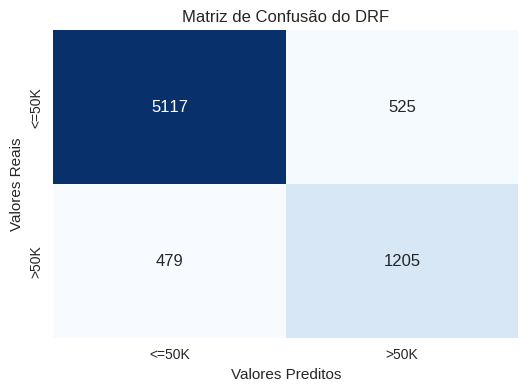

In [ ]:
# converter os dados numpy de treino e validação para H2OFrame
# Adicionar um nome para a coluna target para que o H2OFrame a reconheça corretamente
hf_train = h2o.H2OFrame(X, column_names=[f'feature_{i}' for i in range(X.shape[1])] + ['income'])
hf_valid = h2o.H2OFrame(X_val, column_names=[f'feature_{i}' for i in range(X_val.shape[1])] + ['income'])

# Now, add the target column to the H2OFrames, explicitly casting to int
hf_train['income'] = h2o.H2OFrame(y.reshape(-1, 1).astype(int), column_names=['income'])
hf_valid['income'] = h2o.H2OFrame(y_val.reshape(-1, 1).astype(int), column_names=['income'])


# definir o nome da coluna target pra não mudar meu y original
target_col = 'income' # Defina o nome da coluna target aqui

# redefinir coluna target como categórica para classificação, que é a forma queo H2OFrame trabalha
hf_train[target_col] = hf_train[target_col].asfactor()
hf_valid[target_col] = hf_valid[target_col].asfactor()

# recuperar o modelo DRF do AutoML pelo model_id para extrair parâmetros
drf_model_id = "DRF_1_AutoML_1_20250821_194931"  # ID do modelo DRF no AutoML
automl_drf = h2o.get_model(drf_model_id)

# extrair hiperparâmetros do DRF do AutoML
ntrees = automl_drf.params['ntrees']['actual']
max_depth = int(automl_drf.params['max_depth']['actual'])
min_rows = int(automl_drf.params['min_rows']['actual'])

# Criar e configurar modelo DRF manually with extracted parameters
model_drf = H2ORandomForestEstimator(
    ntrees=ntrees,
    max_depth=max_depth,
    min_rows=min_rows,
    seed=42
)

# treinar o modelo DRF manualmente
model_drf.train(x=hf_train.columns[:-1], y=target_col, training_frame=hf_train, validation_frame=hf_valid) # Pass the column name string

# make predictions on the validation set
preds = model_drf.predict(hf_valid)
y_val_pred = preds.as_data_frame()['predict']

# calculate metrics
accuracy_drf = accuracy_score(y_val, y_val_pred)
precision_drf = precision_score(y_val, y_val_pred)
recall_drf = recall_score(y_val, y_val_pred)
f1_drf = f1_score(y_val, y_val_pred)
classification_report_drf = classification_report(y_val, y_val_pred)
confusion_matrix_drf = confusion_matrix(y_val, y_val_pred)
print(f"F1-Score do DRF: {f1_drf:.4f}")
print(f"Acurácia do DRF: {accuracy_drf:.4f}")
print(f"Recall do DRF: {recall_drf:.4f}")
print(f"Precisão do DRF: {precision_drf:.4f}")
print(f"Relatório de Classificação do DRF:\n{classification_report_drf}")

# plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix_drf, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Valores Preditos')
plt.ylabel('Valores Reais')
plt.title('Matriz de Confusão do DRF')
plt.show()

### III -> Extra Trees Classifier

- F1-Score do XRT: 0.6682
- Acurácia do XRT: 0.8643
- Recall do XRT: 0.5944
- Precisão do XRT: 0.7630
- Relatório de Classificação do XRT:
              precision    recall  f1-score   support

           0       0.89      0.94      0.91      5642
           1       0.76      0.59      0.67      1684

      accuracy                         0.86      7326
      macro avg    0.82      0.77      0.79      7326
      weighted avg 0.86      0.86      0.86      7326

F1-Score do XRT: 0.6682
Acurácia do XRT: 0.8643
Recall do XRT: 0.5944
Precisão do XRT: 0.7630
Relatório de Classificação do XRT:
              precision    recall  f1-score   support

           0       0.89      0.94      0.91      5642
           1       0.76      0.59      0.67      1684

    accuracy                           0.86      7326
   macro avg       0.82      0.77      0.79      7326
weighted avg       0.86      0.86      0.86      7326



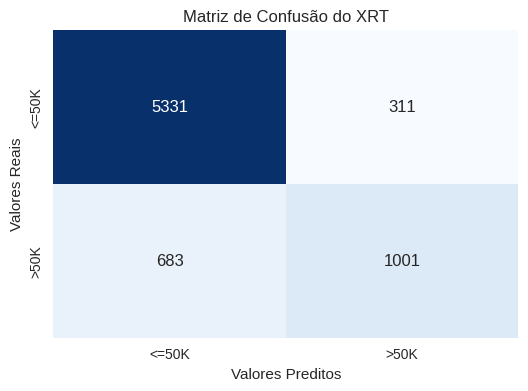

In [46]:
# recuperar o modelo ExtraTreesClassifier do AutoML pelo model_id
model_id = "XRT_1_AutoML_1_20250822_125504"
automl_xrt = h2o.get_model(model_id)

# extrair os hiperparâmetros para referência
# print(automl_xrt.params)

# definir o modelo base xrtClassifier com hiperparâmetros iniciais aproximados do modelo AutoML
model_xrt = ExtraTreesClassifier(
    n_estimators=automl_xrt.params['ntrees']['actual'],
    max_depth=int(automl_xrt.params['max_depth']['actual']),
    min_samples_split=3, #int(automl_xrt.params['min_rows']['actual']),
    random_state=42,
    n_jobs=-1
)

# treinar o modelo
model_xrt.fit(X_scaled, y_encoded)

# fazer as previsões
y_val_pred = model_xrt.predict(X_val_scaled)

# calcular as métricas
accuracy_xrt = accuracy_score(y_val_encoded, y_val_pred)
precision_xrt = precision_score(y_val_encoded, y_val_pred)
recall_xrt = recall_score(y_val_encoded, y_val_pred)
f1_xrt = f1_score(y_val_encoded, y_val_pred)
classification_report_xrt = classification_report(y_val_encoded, y_val_pred)
confusion_matrix_xrt = confusion_matrix(y_val_encoded, y_val_pred)
print(f"F1-Score do XRT: {f1_xrt:.4f}")
print(f"Acurácia do XRT: {accuracy_xrt:.4f}")
print(f"Recall do XRT: {recall_xrt:.4f}")
print(f"Precisão do XRT: {precision_xrt:.4f}")
print(f"Relatório de Classificação do XRT:\n{classification_report_xrt}")

# plotar matriz de confusão
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix_xrt, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=le_target.classes_, yticklabels=le_target.classes_)
plt.xlabel('Valores Preditos')
plt.ylabel('Valores Reais')
plt.title('Matriz de Confusão do XRT')
plt.show()

### Modelos criados manualmente
Por mais que eu já tivesse o top 3 do AutoML, eu quis criar mais 3 modelos manualmente para fins de teste e fiquei impressionado com o resultado do GradientBoostingClassifier que teve um F1 Score melhor que o top 1 do AutoML.

### I > GradientBoostingClassifier

Melhores parâmetros encontrados:
`{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0}`

- F1-Score do GB: 0.7232
- Acurácia do GB: 0.8811
- Recall do GB: 0.6758
- Precisão do GB: 0.7779
- Relatório de Classificação do GB:
              precision    recall  f1-score   support

           0       0.91      0.94      0.92      5642
           1       0.78      0.68      0.72      1684

      accuracy                         0.88      7326
      macro avg    0.84      0.81      0.82      7326
      weighted avg 0.88      0.88      0.88      7326

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Melhores parâmetros encontrados:
{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0}
F1-Score do GB: 0.7232
Acurácia do GB: 0.8811
Recall do GB: 0.6758
Precisão do GB: 0.7779
Relatório de Classificação do GB:
              precision    recall  f1-score   support

           0       0.91      0.94      0.92      5642
           1       0.78      0.68      0.72      1684

    accuracy                           0.88      7326
   macro avg       0.84      0.81      0.82      7326
weighted avg       0.88      0.88      0.88      7326



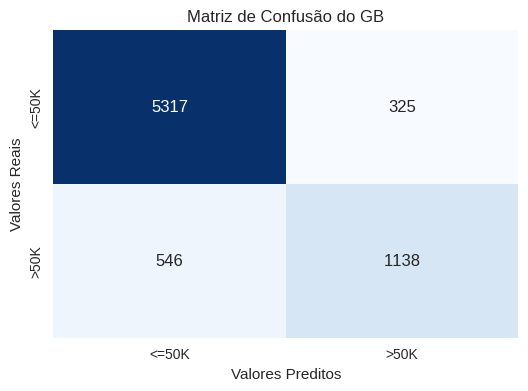

In [47]:
# criar o modelo com GradientBoostingClassifier
gb = GradientBoostingClassifier(random_state=42)

# usar o gridsearch pro fine-tuning
param_grid_gb = {
    'n_estimators': [200, 300],
    'max_depth': [5, 6],
    'learning_rate': [0.05, 0.1],
    'subsample': [1.0]
}

# configuração do GridSearchCV
grid_search_gb = GridSearchCV(
    estimator=gb,
    param_grid=param_grid_gb,
    scoring='f1',
    cv=3,  # Número de folds na validação cruzada
    n_jobs=-1,  # Usa todos os processadores disponíveis
    verbose=2
)

# rodar o GridSearch na base de treino
grid_search_gb.fit(X_scaled, y_encoded)

# mostrar os melhores parâmetros e o melhor score
print("Melhores parâmetros encontrados:")
print(grid_search_gb.best_params_)

# usar o melhor modelo para avaliar na validação
best_gb = grid_search_gb.best_estimator_

# fazer as previsões
y_val_pred = best_gb.predict(X_val_scaled)

# calcular as métricas
accuracy_gb = accuracy_score(y_val_encoded, y_val_pred)
precision_gb = precision_score(y_val_encoded, y_val_pred)
recall_gb = recall_score(y_val_encoded, y_val_pred)
f1_gb = f1_score(y_val_encoded, y_val_pred)
classification_report_gb = classification_report(y_val_encoded, y_val_pred)
confusion_matrix_gb = confusion_matrix(y_val_encoded, y_val_pred)
print(f"F1-Score do GB: {f1_gb:.4f}")
print(f"Acurácia do GB: {accuracy_gb:.4f}")
print(f"Recall do GB: {recall_gb:.4f}")
print(f"Precisão do GB: {precision_gb:.4f}")
print(f"Relatório de Classificação do GB:\n{classification_report_gb}")

# plotar matriz de confusão
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix_gb, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=le_target.classes_, yticklabels=le_target.classes_)
plt.xlabel('Valores Preditos')
plt.ylabel('Valores Reais')
plt.title('Matriz de Confusão do GB')
plt.show()

### II -> RandomForest

Melhores parâmetros encontrados:
`{'class_weight': 'balanced', 'max_depth': 19, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400}`

- F1-Score do RF: 0.6975
- Acurácia do RF: 0.8445
- Recall do RF: 0.7797
- Precisão do RF: 0.6309
- Relatório de Classificação do RF:
              precision    recall  f1-score   support

           0       0.93      0.86      0.90      5642
           1       0.63      0.78      0.70      1684

      accuracy                         0.84      7326
      macro avg    0.78      0.82      0.80      7326
      weighted avg 0.86      0.84      0.85      7326


Fitting 3 folds for each of 3 candidates, totalling 9 fits
Melhores parâmetros encontrados:
{'class_weight': 'balanced', 'max_depth': 19, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400}
F1-Score do RF: 0.6975
Acurácia do RF: 0.8445
Recall do RF: 0.7797
Precisão do RF: 0.6309
Relatório de Classificação do RF:
              precision    recall  f1-score   support

           0       0.93      0.86      0.90      5642
           1       0.63      0.78      0.70      1684

    accuracy                           0.84      7326
   macro avg       0.78      0.82      0.80      7326
weighted avg       0.86      0.84      0.85      7326



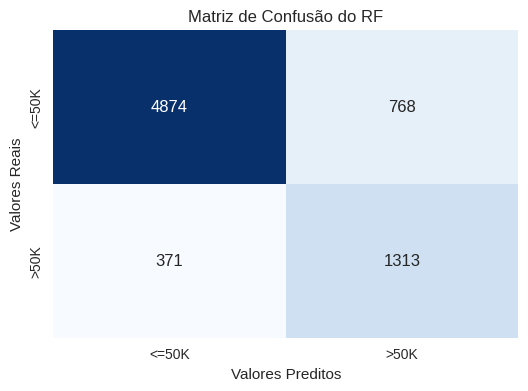

In [48]:
# criar o modelo com RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# usar o gridsearch pro fine-tuning
param_grid_rf = {
    'n_estimators': [400], # número de árvores da floresta
    'max_depth': [17, 19, 21], # profundidade máxima que cada árvore pode descer
    'min_samples_split': [2], # número mínimo de amostras necessárias pra dividir um nó
    'min_samples_leaf': [1], # número mínimo de amostras que devem estar presentes em um nó
    'class_weight': ['balanced']  # serve para lidar com classes desbalanceadas atribuindo pesos diferentes para cada classe durante o treinamento
}

# configuração do GridSearchCV
grid_search_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid_rf,
    scoring='f1',
    cv=3,  # Número de folds na validação cruzada
    n_jobs=-1,  # Usa todos os processadores disponíveis
    verbose=2
)

# rodar o GridSearch na base de treino
grid_search_rf.fit(X_scaled, y_encoded)

# mostrar os melhores parâmetros e o melhor score
print("Melhores parâmetros encontrados:")
print(grid_search_rf.best_params_)

# usar o melhor modelo para avaliar na validação
best_rf = grid_search_rf.best_estimator_

# fazer as previsões
y_val_pred = best_rf.predict(X_val_scaled)

# calcular as métricas
accuracy_rf = accuracy_score(y_val_encoded, y_val_pred)
precision_rf = precision_score(y_val_encoded, y_val_pred)
recall_rf = recall_score(y_val_encoded, y_val_pred)
f1_rf = f1_score(y_val_encoded, y_val_pred)
classification_report_rf = classification_report(y_val_encoded, y_val_pred)
confusion_matrix_rf = confusion_matrix(y_val_encoded, y_val_pred)
print(f"F1-Score do RF: {f1_rf:.4f}")
print(f"Acurácia do RF: {accuracy_rf:.4f}")
print(f"Recall do RF: {recall_rf:.4f}")
print(f"Precisão do RF: {precision_rf:.4f}")
print(f"Relatório de Classificação do RF:\n{classification_report_rf}")

# plotar matriz de confusão
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix_rf, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=le_target.classes_, yticklabels=le_target.classes_)
plt.xlabel('Valores Preditos')
plt.ylabel('Valores Reais')
plt.title('Matriz de Confusão do RF')
plt.show()

### III -> NaiveBayes
Melhores parâmetros encontrados: `{'var_smoothing': 1e-09}`
- F1-Score do NB: 0.4535
- Acurácia do NB: 0.8105
- Recall do NB: 0.3420
- Precisão do NB: 0.6729
- Relatório de Classificação do NB:
              precision    recall  f1-score   support

           0       0.83      0.95      0.89      5642
           1       0.67      0.34      0.45      1684

      accuracy                         0.81      7326
      macro avg    0.75      0.65      0.67      7326
      weighted avg 0.79      0.81      0.79      7326


Fitting 3 folds for each of 4 candidates, totalling 12 fits
Melhores parâmetros encontrados:
{'var_smoothing': 1e-09}
F1-Score do NB: 0.4535
Acurácia do NB: 0.8105
Recall do NB: 0.3420
Precisão do NB: 0.6729
Relatório de Classificação do NB:
              precision    recall  f1-score   support

           0       0.83      0.95      0.89      5642
           1       0.67      0.34      0.45      1684

    accuracy                           0.81      7326
   macro avg       0.75      0.65      0.67      7326
weighted avg       0.79      0.81      0.79      7326



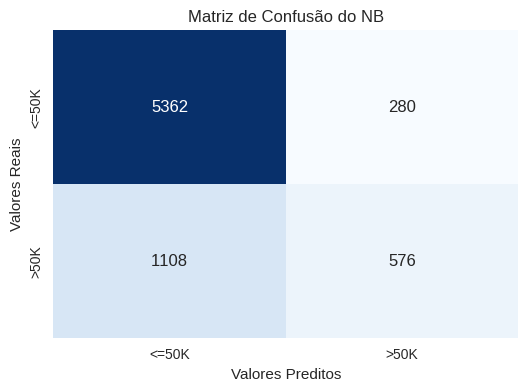

In [49]:
# criar o modelo com NaiveBayes
nb = GaussianNB()

# usar o gridsearch pro fine-tuning
param_grid_nb = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]
}

# configuração do GridSearchCV
grid_search_nb = GridSearchCV(
    estimator=nb,
    param_grid=param_grid_nb,
    scoring='f1',
    cv=3,  # Número de folds na validação cruzada
    n_jobs=-1,  # Usa todos os processadores disponíveis
    verbose=2
)

# rodar o GridSearch na base de treino
grid_search_nb.fit(X_scaled, y_encoded)

# mostrar os melhores parâmetros e o melhor score
print("Melhores parâmetros encontrados:")
print(grid_search_nb.best_params_)

# usar o melhor modelo para avaliar na validação
best_nb = grid_search_nb.best_estimator_

# fazer as previsões
y_val_pred = best_nb.predict(X_val_scaled)

# calcular as métricas
accuracy_nb = accuracy_score(y_val_encoded, y_val_pred)
precision_nb = precision_score(y_val_encoded, y_val_pred)
recall_nb = recall_score(y_val_encoded, y_val_pred)
f1_nb = f1_score(y_val_encoded, y_val_pred)
classification_report_nb = classification_report(y_val_encoded, y_val_pred)
confusion_matrix_nb = confusion_matrix(y_val_encoded, y_val_pred)
print(f"F1-Score do NB: {f1_nb:.4f}")
print(f"Acurácia do NB: {accuracy_nb:.4f}")
print(f"Recall do NB: {recall_nb:.4f}")
print(f"Precisão do NB: {precision_nb:.4f}")
print(f"Relatório de Classificação do NB:\n{classification_report_nb}")

# plotar matriz de confusão
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix_nb, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=le_target.classes_, yticklabels=le_target.classes_)
plt.xlabel('Valores Preditos')
plt.ylabel('Valores Reais')
plt.title('Matriz de Confusão do NB')
plt.show()

## Teste do modelo vencedor (Gradient Boosting)
O teste é feito na base de teste, que ainda não foi passada para o modelo não ficar enviezado

### Importação da base de teste

In [50]:
# importar a base de testes
test = pd.read_csv('test.csv')

# olhar a estrutura da tabela de teste
test.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,23,Private,33021,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,<=50K
2,21,Private,139722,HS-grad,9,Never-married,Craft-repair,Not-in-family,White,Male,0,0,40,Puerto-Rico,<=50K
3,45,Local-gov,272182,Some-college,10,Married-civ-spouse,Tech-support,Husband,Black,Male,5013,0,40,United-States,<=50K
4,59,Private,158776,9th,5,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,<=50K


In [51]:
# verificar se tem dados nulos em alguma coluna do teste
test.isnull().sum()

,0
age,0
workclass,0
fnlwgt,0
education,0
educational-num,0
marital-status,0
occupation,0
relationship,0
race,0
gender,0


In [52]:
# ver o tamanho da base de testes
test.shape

(7327, 15)

In [53]:
# verificar dados faltantes no teste
test.select_dtypes(include=['object']).apply(lambda x: x.str.contains(r'\?', na=False).sum())

,0
workclass,426
education,0
marital-status,0
occupation,427
relationship,0
race,0
gender,0
native-country,134
income,0


In [54]:
# substituir o '?' por 'Not-informed'
test.replace('?', 'Not-informed', inplace=True)

# verificar se funcionou
test.select_dtypes(include=['object']).apply(lambda x: x.str.contains(r'\?', na=False).sum())

,0
workclass,0
education,0
marital-status,0
occupation,0
relationship,0
race,0
gender,0
native-country,0
income,0


### Definição das variáveis da base de teste

In [55]:
# definição das variáveis
y_test = test.iloc[:, 14] # variável dependente (alvo)
X_test = test.drop(test.columns[14], axis=1) # variáveis independentes

# confirmar os tamanhos das bases
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")

X_test: (7327, 14)
y_test: (7327,)


### Pre processamento da base de teste

In [56]:
# Outliers na base teste
# detectar e listar colunas numéricas no conjunto de teste
colunas_numericas = X_test.select_dtypes(include=['int64', 'float64']).columns
print(colunas_numericas)

# dicionário para armazenar resultados dos outliers no teste
outliers_test = {}

for coluna in colunas_numericas:
    # usar os limites calculados no treino
    limite_inf = resultados_iqr[coluna]['limite_inf']
    limite_sup = resultados_iqr[coluna]['limite_sup']

    # detectar outliers no teste
    outliers = X_test[(X_test[coluna] < limite_inf) | (X_test[coluna] > limite_sup)]

    outliers_test[coluna] = {
        'limite_inf': limite_inf,
        'limite_sup': limite_sup,
        'outliers': len(outliers)
    }

# imprimir resultados no teste
for coluna in outliers_test:
    print(f"Outliers para {coluna}: {outliers_test[coluna]['outliers']} "\
          f"(Limite inf: {outliers_test[coluna]['limite_inf']}, Limite sup: {outliers_test[coluna]['limite_sup']})")

Index(['age', 'fnlwgt', 'educational-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object')
Outliers para age: 29 (Limite inf: -2.0, Limite sup: 78.0)
Outliers para fnlwgt: 206 (Limite inf: -66598.0, Limite sup: 422042.0)
Outliers para educational-num: 253 (Limite inf: 4.5, Limite sup: 16.5)
Outliers para capital-gain: 605 (Limite inf: 0.0, Limite sup: 0.0)
Outliers para capital-loss: 322 (Limite inf: 0.0, Limite sup: 0.0)
Outliers para hours-per-week: 1950 (Limite inf: 32.5, Limite sup: 52.5)


In [59]:
# Categorização da base teste
# ver as colunas categóticas do tipo object
print("\nColunas categóricas na base de testes", X_test.dtypes[X_test.dtypes == 'object'])

# criar uma variável X_test_encoded pra manter X_test intacto com dados brutos
X_test_encoded = X_test.copy()

# transforma colunas de X_test do tipo object em numéricas
for coluna in X_test_encoded.select_dtypes(include=['object']).columns:
    le = label_encoders.get(coluna)
    X_test_encoded[coluna] = le.transform(X_test_encoded[coluna])

# transforma o y_test de objeto para numérico
y_test_encoded = le_target.transform(y_test)

# Verifica que não sobra coluna do tipo 'object'
print("\nCounas da base de testes: ", X_test_encoded.dtypes)
print("Valores únicos y_test_encoded: ", np.unique(y_test_encoded))


Colunas categóricas na base de testes workclass         object
education         object
marital-status    object
occupation        object
relationship      object
race              object
gender            object
native-country    object
dtype: object

Counas da base de testes:  age                int64
workclass          int64
fnlwgt             int64
education          int64
educational-num    int64
marital-status     int64
occupation         int64
relationship       int64
race               int64
gender             int64
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country     int64
dtype: object
Valores únicos y_test_encoded:  [0 1]


In [60]:
# Dimensionamento (normalização com StandardScaler)
# escala usando o scaler treinado (sc.transform)
X_test_scaled = sc.transform(X_test_encoded) # na base de teste, assim como na base de validação, uso apenas o transform() para não vazar as infos do conjunto de validação pro modelo

# verifica média e desvio após escala
print("Média da base de teste escalado: ", X_test_scaled[:, 3].mean())
print("Desvio Padrão da base de teste escalado: ", X_test_scaled[:, 3].std())

Média da base de teste escalado:  -0.015371140931007572
Desvio Padrão da base de teste escalado:  0.9976233304128338


### Calcular as métricas do melhor modelo (GradientBoostingClassivier)

F1-Score do GB: 0.7300
Acurácia do GB: 0.8814
Recall do GB: 0.6768
Precisão do GB: 0.7923
Relatório de Classificação do GB:
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      5591
           1       0.79      0.68      0.73      1736

    accuracy                           0.88      7327
   macro avg       0.85      0.81      0.83      7327
weighted avg       0.88      0.88      0.88      7327



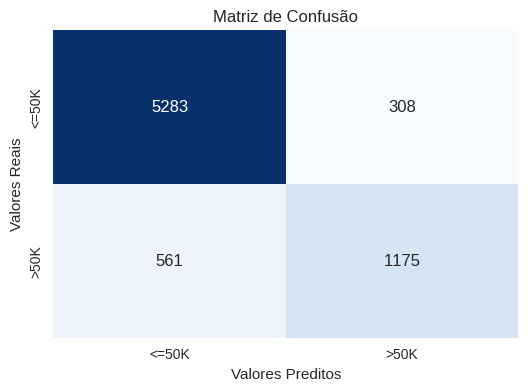

In [61]:
# fazer as previsões
y_test_pred = best_gb.predict(X_test_scaled)

# calcular as métricas
accuracy_test = accuracy_score(y_test_encoded, y_test_pred)
precision_test = precision_score(y_test_encoded, y_test_pred)
recall_test = recall_score(y_test_encoded, y_test_pred)
f1_test = f1_score(y_test_encoded, y_test_pred)
classification_report_test = classification_report(y_test_encoded, y_test_pred)
confusion_matrix_test = confusion_matrix(y_test_encoded, y_test_pred)
print(f"F1-Score do GB: {f1_test:.4f}")
print(f"Acurácia do GB: {accuracy_test:.4f}")
print(f"Recall do GB: {recall_test:.4f}")
print(f"Precisão do GB: {precision_test:.4f}")
print(f"Relatório de Classificação do GB:\n{classification_report_test}")

# plotar matriz de confusão
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix_test, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=le_target.classes_, yticklabels=le_target.classes_)
plt.xlabel('Valores Preditos')
plt.ylabel('Valores Reais')
plt.title('Matriz de Confusão')
plt.show()

### Resultado Final
- F1-Score do GB: 0.7300
- Acurácia do GB: 0.8814
- Recall do GB: 0.6768
- Precisão do GB: 0.7923
- Relatório de Classificação do GB:
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      5591
           1       0.79      0.68      0.73      1736

      accuracy                         0.88      7327
      macro avg    0.85      0.81      0.83      7327
      weighted avg 0.88      0.88      0.88      7327


**F1-Score (0.73):** Indica um equilíbrio saudável entre a precisão (0.79) e o recall (0.68) para a classe positiva, que geralmente é a mais difícil de classificar corretamente.

**Acurácia (0.88):** Alta acurácia geral, o que é positivo, mas para conjuntos desbalanceados o F1 é mais indicado.

**Precisão (0.79) para classe 1:** Boa capacidade do modelo em evitar falsos positivos.

**Recall (0.68) para classe 1:** Pode ser melhorado, pois indica que o modelo perde alguns verdadeiros positivos, mas ainda é um valor razoável.

**Relatório de classificação:** mostra que a classe 0 tem um desempenho muito forte (92% de f1).


**Ranking final dos modelos**
Incluindo os novos modelos na comparação, temos a seguinte tabela completa:

| Ranking | Modelo                      | F1-Score |
|---------|-----------------------------|----------|
| 1º      | GradientBoosting            | 0.7232   |
| 2º      | XGBoosting (AutoML - XGB)   | 0.7022   |
| 3º      | Extra Trees Classifier (AutoML - XRT) | 0.7011   |
| 4º      | RandomForest                | 0.6975   |
| 5º      | GradientBoosting Annealing (AutoML - GBA) | 0.6893   |
| 6º      | NaiveBayes                  | 0.4535   |


## XAI do modelo Vencedor (Gradient Boosting)

In [63]:
# instalar a biblioteca
!pip install shap

 99%|===================| 7280/7327 [00:26<00:00]       

Visualização Glogal - importancia e efeito das features


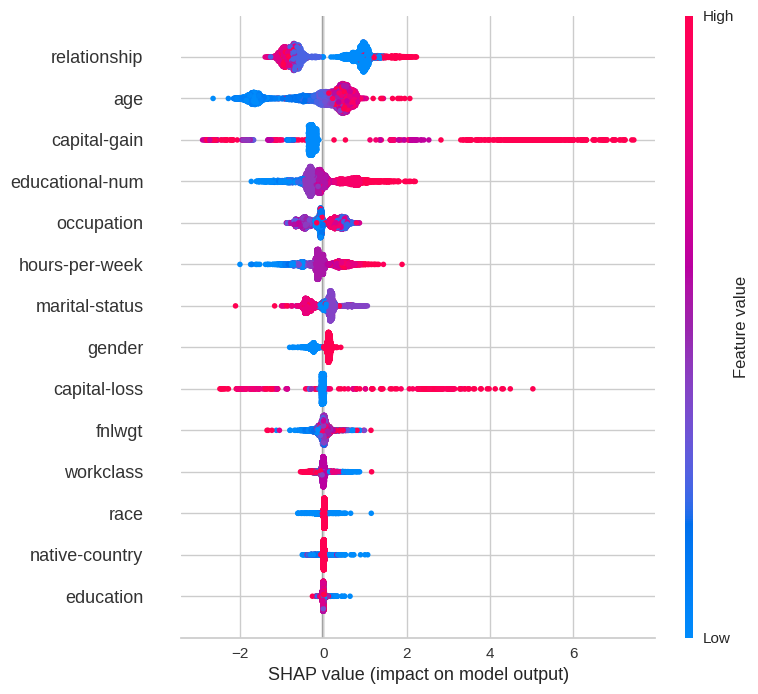

Visualização Local - uma única predição para a primeira amostra da base de testes


In [72]:
# importar o modelo
import shap

# cria DataFrame com os dados de treino escalados, para construir o explicador
X_train_scaled_df = pd.DataFrame(X_scaled, columns=X_test_encoded.columns)

# cria o explicador usando os dados de treino (obrigatório para capturar a distribuição real)
explainer = shap.TreeExplainer(best_gb, data=X_train_scaled_df)

# cria o DataFrame com os dados de teste escalados, para calcular os valores SHAP
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test_encoded.columns)

# calcular os valores shap para a base de testes escalada
shap_values = explainer.shap_values(X_test_scaled_df, check_additivity=False)

# fazer a visualização global pra ver a importancia e efeito das features
print("\nVisualização Glogal - importancia e efeito das features")
shap.summary_plot(shap_values, X_test_scaled_df)

# fazer a visualização local pra uma única predição (ex: primeira amostra)
shap.initjs()
print("\nVisualização Local - uma única predição para a primeira amostra da base de testes")
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test_scaled_df.iloc[0,:])

### Interpretação do resultado com o SHAP
**Como interpretar o gráfico**

**Eixo Y (variáveis/features):** cada linha representa uma variável usada no modelo, ordenadas pela importância média.

**Eixo X (valor SHAP):** representa o impacto daquela variável na predição, em termos de contribuição para aumentar (valores positivos) ou diminuir (valores negativos) a probabilidade da classe positiva (no seu caso, renda > 50K).

**Pontos coloridos em cada linha:** cada ponto representa uma instância (amostra) do dataset de teste.

*A cor indica o valor da variável naquela amostra: vermelho = valor alto, azul = valor baixo.*

*A posição horizontal do ponto indica o impacto daquele valor da variável na predição do modelo.*

---

**Exemplo prático de interpretação**
Para a variável capital-gain:

Muitos pontos vermelhos (valores altos de capital-gain) estão à direita no gráfico (SHAP positivo), indicando que valores altos dessa variável aumentam a probabilidade da renda ser > 50K.

Pontos azuis (valores baixos) tendem a diminuir a probabilidade (SHAP negativo).

Para variável age:

Valores altos (vermelhos) têm um impacto moderado positivo na predição.

Valores baixos (azuis) são posicionados mais à esquerda, indicando impacto negativo.

Variáveis com pontos próximos ao zero no eixo X têm impacto neutro naquela predição específica.

A ordem das variáveis no eixo Y indica as mais influentes globalmente (no topo, como relationship, age, capital-gain).

---

**Uso prático**

**Importância das features:** O gráfico ajuda a entender que variáveis têm maior peso nas decisões do modelo.

**Comportamento condicionado:** Mostra como diferentes níveis de valores impactam a previsão, revelando relações e possíveis pontos de corte.

**Identificação de padrões:** Pode sugerir, por exemplo, que pessoas com alto capital-gain e certo relacionamento têm alta probabilidade de renda acima de 50K.